# Lagrangian model for the simulation of dispersion over sloping terrain due to thermally driven slope winds 

Single particle (SP) Lagrangian model with the following characteristics:
* only transport due to the mean wind along x direction (no diffusion)
* homogeneous isotropic turbulence, without boundaries, along y direction (source at ys=0)
* homogeneous isotropic turbulence, with boundaries (at ground and at PBL height) along z (source at zs=he)



In [1]:
import numpy as np
import scipy 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset
from matplotlib import cm
from collections import OrderedDict
import matplotlib.pylab as pl
from scipy.interpolate import interp1d
import xarray
from scipy.stats import norm
import seaborn as sns
m = 20
colors = pl.cm.viridis(np.linspace(0,1,m)) # inferno (warm) o viridis (cold)

In [2]:
# PARAMETERS 

nstep = 1000          # number of time steps
TL = .47              # Lagrangian integral time scale          
dt = TL/100           # time increment
C0 = 4                # constant C0 of Langevin equation  
N = 4000            # number of particles
U = 3                # mean wind 3
Q = 3                 # emission rate 3 start value
pblh = 15             # PBL height
he = 10               # height of the source

#variances of random numbers for initializing the particles velocities 

sigmav2 = .47089      #along y
sigmaw2 = 4.7089      #along z

#standard deviations of randon numbers for initializing the particles positions

sy = .0176239          #sy takes source size along y into account 
sz = .0176239          #sz takes source size along z into account 


In [3]:
# Initilization of random variables

#Index for random terms
rr = 1

#random number with variance dt
mu, sigma = 0, np.sqrt(dt)
random = np.random.normal(mu, sigma, N*nstep+10)


#random numbers to initialize the velocities 
sigmav2 = 4 #.047089  
sigmaw2 = 4    #.47089  
epsilon_v = 2*sigmav2/(C0*TL)
epsilon_w = 2*sigmaw2/(C0*TL)
random_vv = np.random.normal(0.0, np.sqrt(sigmav2), N)
random_ww = np.random.normal(0.0, np.sqrt(sigmaw2), N)

In [4]:
# Position at the source 

# sy sz take the source size into account.
sy = .0176239  
sz = .0176239 

# height of the source (H)
he = 10.0

random_yy = np.random.normal(0.0, sy, N)
random_zz= np.random.normal(he, sz, N) 

kky = np.zeros([N,nstep])
kkz = np.zeros([N,nstep])
time = np.zeros([nstep,1])

# cycling now on all the particles

for n in range(1,N-1):
    # initialization of the positions
    yy = random_yy[n]
    zz = random_zz[n]
    
    # initialization of the velocities 
    vm = random_vv[n]
    wm = random_ww[n]
    
    for step in range(0,nstep-1):
        if n ==1:
            time[1] = dt
        else:
            time[step] = time[step-1]+dt
    
    # computation of the coefficients a and b for the systems of Langevin and position equation for y and z 
    # the definition of a is done using the Hinze relationship between the Lagrangian time scale and the dissipation rate
    # [Hinze relation:  C0*epsilon = 2sigmau^2/TL]
    
        av = -vm/TL
        bv = np.sqrt(C0*epsilon_v)
        aw = -wm/TL
        bw = np.sqrt(C0*epsilon_w)
    
    # computation of the positions and the velocities at the new timestep
        vm = vm + av*dt + bv*random[rr]
        yy = yy + vm*dt
        wm = wm + aw*dt + bw*random[rr]
        zz = zz + wm*dt
   
    # boundary conditions 
        if zz <= 0:
            wm = abs(wm)
            zz = zz
            # lower boundary
    
        if zz >= pblh:
            print(wm)
            wm = -abs(wm) # cambiare questo per deposizione
            zz = zz
            # higher boundary
    
        kky[n,step] = yy
        kkz[n,step] = zz
    
        rr=rr+1
        
# end of the cycle for the timestep
# end of the cycle on the particles

2.172421948974237
5.339440325478842
3.337132924615794
3.636377972618906
2.12909176473884
2.919184562259015
2.403861001355388
4.513441608068612
3.3973907447915566
4.277281723457342
5.321728327101617
2.533543693777271
1.2968425922529567
4.768086217513913
1.1710518914853685
2.3549887708199764
1.7366762320453661
0.8371788386084442
3.1211562559588724
1.6920779354403492
2.00558256228828
2.6762370379245795
1.8278267352756803
1.039180782845484
1.7091306547039258
4.6052261215351145
3.0920906627422458
3.974842581279005
1.7229444270484469
4.257969805932543
4.070600040814585
2.3601865126578687
3.001252611812251
4.84864541205743
3.2643893402781665
2.110295505151159
-1.4710762065580427
4.7077742718481215
3.0798546974604224
2.3954328987786577
1.406594486788605
1.8508785694610999
4.755117208847515
1.8178926591097628
1.9895427033982678
-1.786796409704852
7.6130735845287445
3.711945263119093
2.1348771662420245
1.9626197074797929
3.724464453200386
2.7977933030884605
3.1218031194840505
1.4730244093711975


In [ ]:
# Evaluating the range to check if the boundary conditions are respected in the z direction 

print(np.min(kkz))
print(np.max(kkz))

print(np.min(kky))
print(np.max(kky))

x = U*time

-0.02197283339531204
15.031898327340107
-15.569996151834731
13.031953029579814


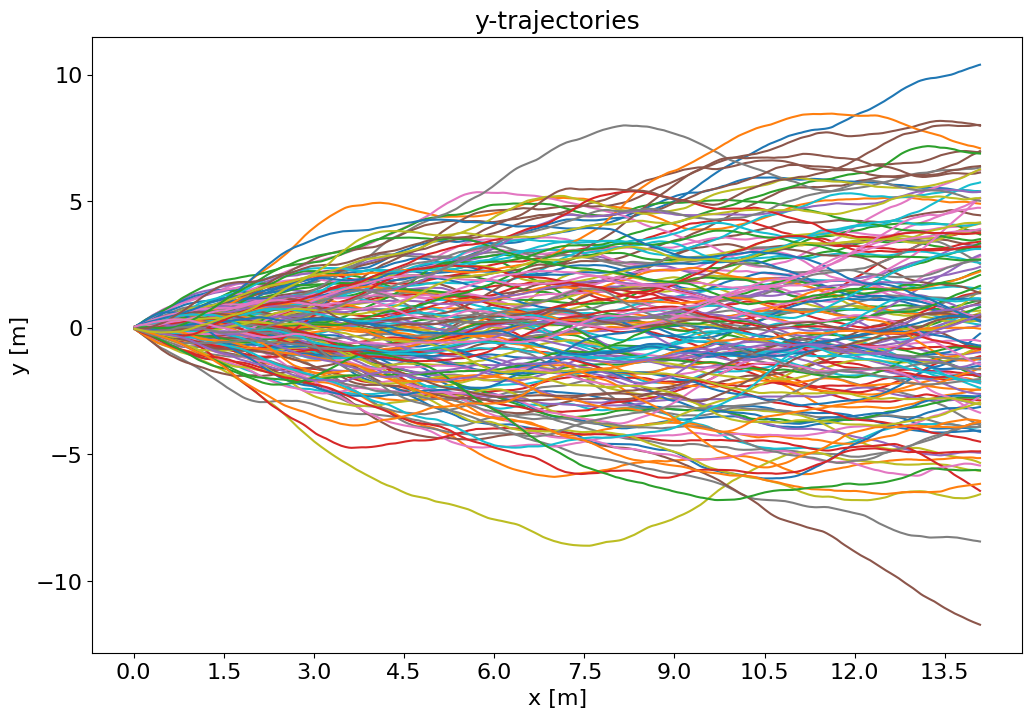

In [ ]:
# plot section (x,y)

fig, ax1 = plt.subplots(figsize=(12, 8))
for i in range(1,150):
    plt.plot(x[0:len(x)-1], kky[i,0:len(x)-1])
plt.xlabel("x [m]", fontsize = 16)
plt.ylabel("y [m]", fontsize = 16)
ax1.xaxis.set_major_locator(plt.MaxNLocator(15))
plt.title("y-trajectories",fontsize = 18)
plt.tick_params(axis='both', labelsize=16)

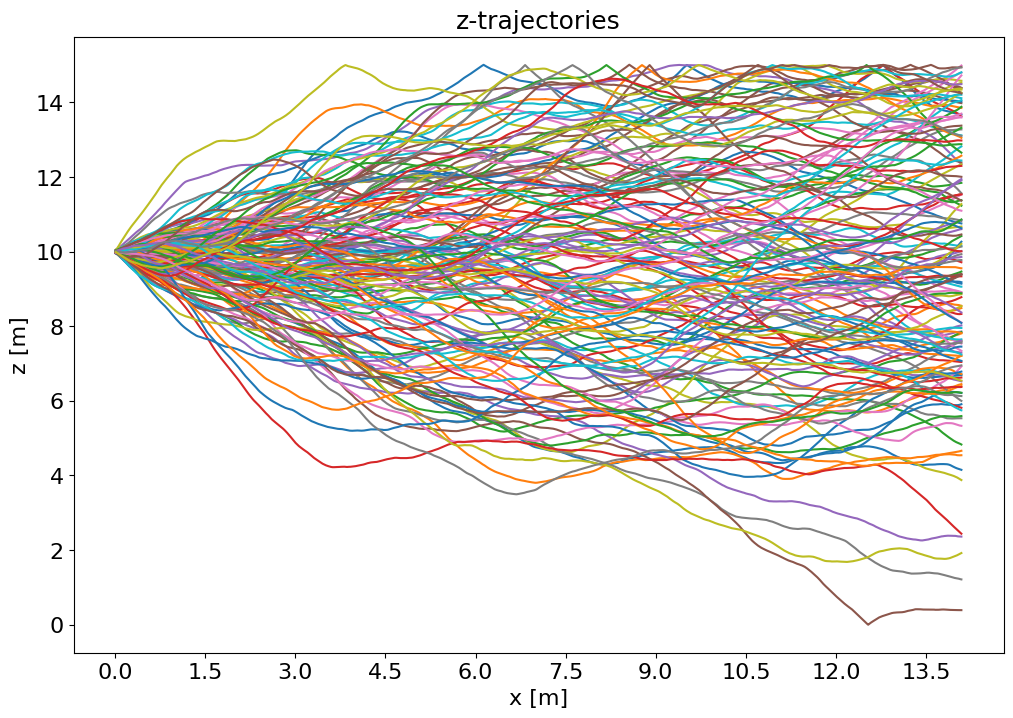

In [ ]:
# plot section (x,y)
fig, ax1 = plt.subplots(figsize=(12, 8))
for i in range(1,150):
    plt.plot(x[0:len(x)-1], kkz[i,0:len(x)-1])
plt.xlabel("x [m]", fontsize = 16)
plt.ylabel("z [m]", fontsize = 16)
ax1.xaxis.set_major_locator(plt.MaxNLocator(15))
plt.title("z-trajectories",fontsize = 18)
plt.tick_params(axis='both', labelsize=16)

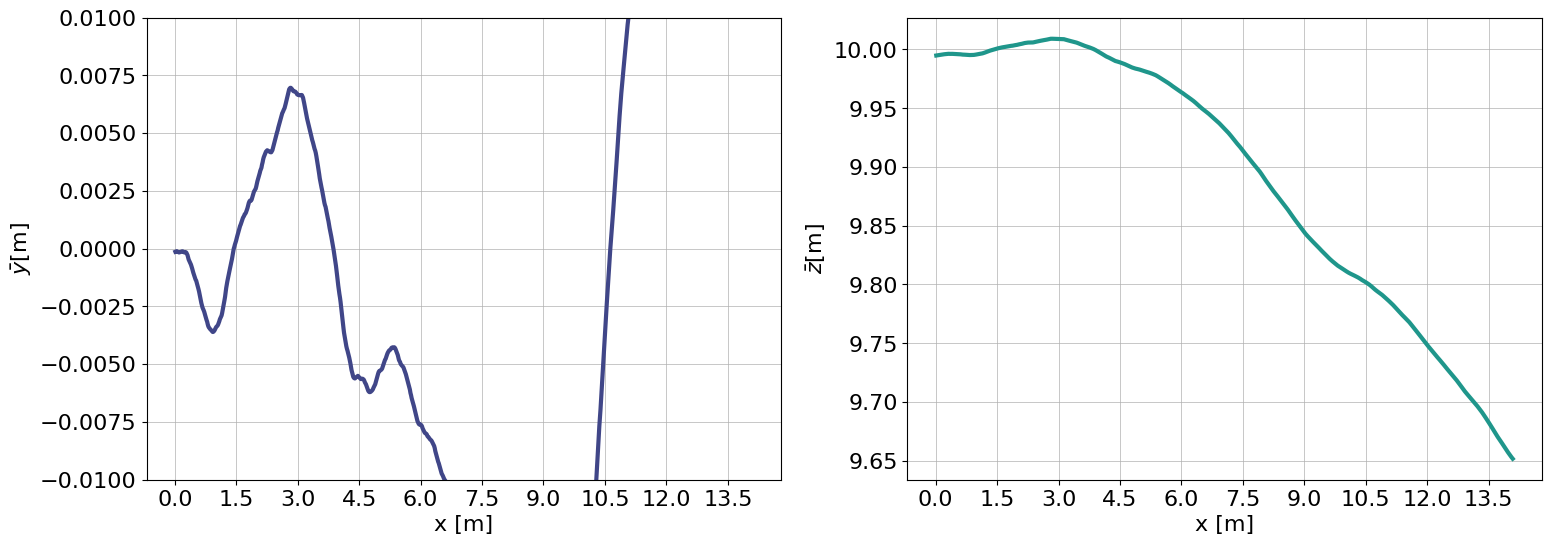

In [ ]:
# mean trajectories along y and z 

mean_y = np.mean(kky[:,0:len(x)-1],0)
mean_z = np.mean(kkz[:,0:len(x)-1],0)

plt.figure(figsize=(18, 6)) 

ax1 = plt.subplot(1,2,1)
plt.plot(x[0:len(x)-1], mean_y[0:len(x)-1], linewidth = 3.0, color = colors[4])
plt.xlabel("x [m]", fontsize = 16)
plt.ylabel(r'$\bar{y}$[m]', fontsize = 16)
ax1.xaxis.set_major_locator(plt.MaxNLocator(15))
plt.ylim([-0.01, 0.01])
plt.tick_params(axis='both', labelsize=16)
plt.grid(linewidth = 0.5)

ax2 = plt.subplot(1,2,2)
plt.plot(x[0:len(x)-1], mean_z[0:len(x)-1], linewidth = 3.0, color = colors[10])
plt.xlabel("x [m]", fontsize = 16)
plt.ylabel(r'$\bar{z}$[m]', fontsize = 16)
ax2.xaxis.set_major_locator(plt.MaxNLocator(15))
#plt.ylim([2.90, 3.1])
plt.tick_params(axis='both', labelsize=16)
plt.grid(linewidth = 0.5)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


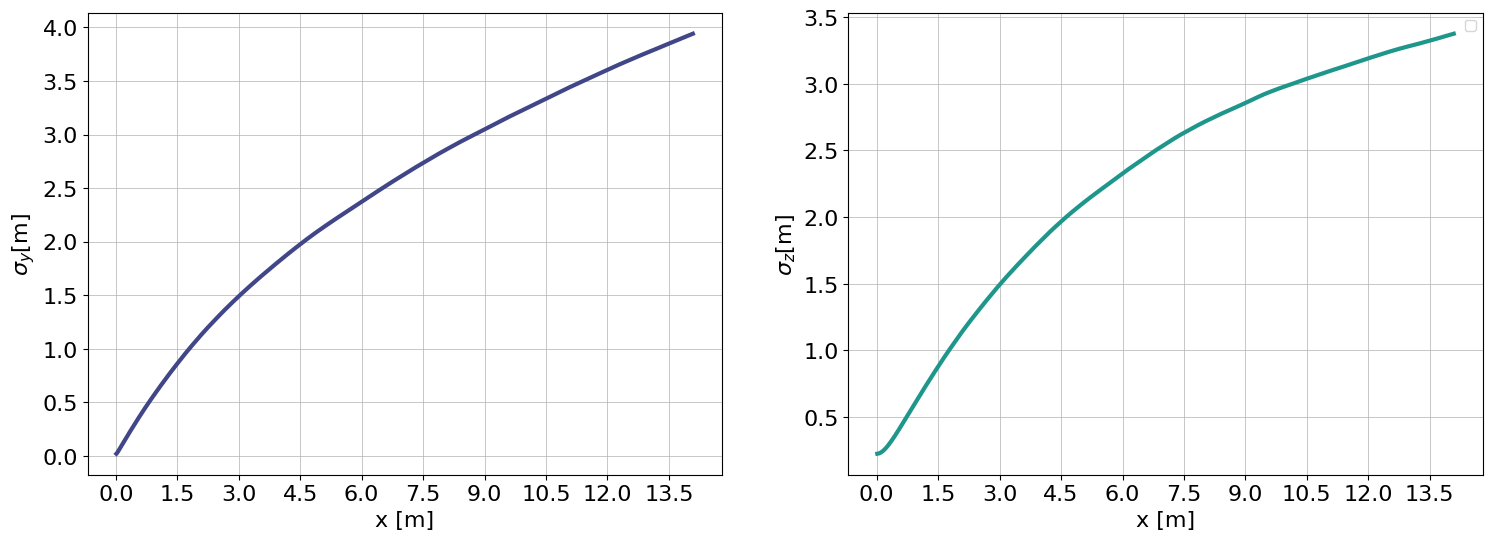

In [ ]:
# calculation of the variances around the trajectories along y and z 
# calculation of the variances around the trajectories along y and z 
d_y = np.std(kky[:,0:len(x)-1],0)
d_z = np.std(kkz[:,0:len(x)-1],0)
plt.figure(figsize=(18, 6)) 

ax1 = plt.subplot(1,2,1)
plt.plot(x[0:len(x)-1], d_y[0:len(x)-1], linewidth = 3.0, color = colors[4])
plt.xlabel("x [m]", fontsize = 16)
plt.ylabel(r'$\sigma_y$[m]', fontsize = 16)
ax1.xaxis.set_major_locator(plt.MaxNLocator(15))
#plt.ylim([-0.01, 0.01])
plt.tick_params(axis='both', labelsize=16)
plt.grid(linewidth = 0.5)

ax2 = plt.subplot(1,2,2)
plt.plot(x[0:len(x)-1], d_z[0:len(x)-1], linewidth = 3.0, color = colors[10]) #copiare

plt.xlabel("x [m]", fontsize = 16)
plt.ylabel(r'$\sigma_z$[m]', fontsize = 16)
ax2.xaxis.set_major_locator(plt.MaxNLocator(15))
#plt.ylim([9.95, 10.05])
plt.tick_params(axis='both', labelsize=16)
plt.grid(linewidth = 0.5)
plt.legend()
# 1) compute the variaces along the trajectories in the x and z direction and plot them 
# 2) compute the variances in x and z for the final timestep - distance for different set of parameters 
# try to act on each subset of parameters individually (i.e. keeping all the other fixed) and try a wide 
# range of values -- we call this kind of analysis SENSITIVITY ANALYSIS and we use it to understand 
# which one are the parameters that have stronger impact on the final configuration of the concentration field
# (i.e. is the mean wind the crucial factor? Are the velocity variances? Is the the emission intensity?)

In [ ]:
plt.figure(figsize=(18, 6)) 

ax1 = plt.subplot(1,2,1)
plt.plot(x[0:len(x)-1], dy_1[0:len(x)-1], linewidth = 2.0, label='devy_1')
plt.plot(x[0:len(x)-1], dy_3[0:len(x)-1], linewidth = 2.0, label='devy_3')
plt.plot(x[0:len(x)-1], dy_5[0:len(x)-1], linewidth = 2.0, label='devy_5')
plt.plot(x[0:len(x)-1], dy_7[0:len(x)-1], linewidth = 2.0, label='devy_7')
plt.plot(x[0:len(x)-1], dy_9[0:len(x)-1], linewidth = 2.0, label='devy_9')
plt.plot(x[0:len(x)-1], dy_11[0:len(x)-1], linewidth = 2.0, label='devy_11')
plt.xlabel("x [m]", fontsize = 16)
plt.ylabel(r'$\sigma_y$[m]', fontsize = 16)
plt.ylim([0.4, 0.5])
plt.xlim([50, 52])
ax1.xaxis.set_major_locator(plt.MaxNLocator(15))
plt.grid(linewidth = 0.5)
plt.legend()

ax2 = plt.subplot(1,2,2)
plt.plot(x[0:len(x)-1], dz_1[0:len(x)-1], linewidth = 2.0, label='devz_1')
plt.plot(x[0:len(x)-1], dz_3[0:len(x)-1], linewidth = 2.0, label='devz_3')
plt.plot(x[0:len(x)-1], dz_5[0:len(x)-1], linewidth = 2.0, label='devz_5')
plt.plot(x[0:len(x)-1], dz_7[0:len(x)-1], linewidth = 2.0, label='devz_7')
plt.plot(x[0:len(x)-1], dz_9[0:len(x)-1], linewidth = 2.0, label='devz_9')
plt.plot(x[0:len(x)-1], dz_11[0:len(x)-1], linewidth = 2.0, label='devz_11')
plt.xlabel("x [m]", fontsize = 16)
plt.ylabel(r'$\sigma_z$[m]', fontsize = 16)
ax1.xaxis.set_major_locator(plt.MaxNLocator(15))
plt.grid(linewidth = 0.5)
plt.ylim([1.2, 1.6])
plt.xlim([50, 52])
plt.legend()

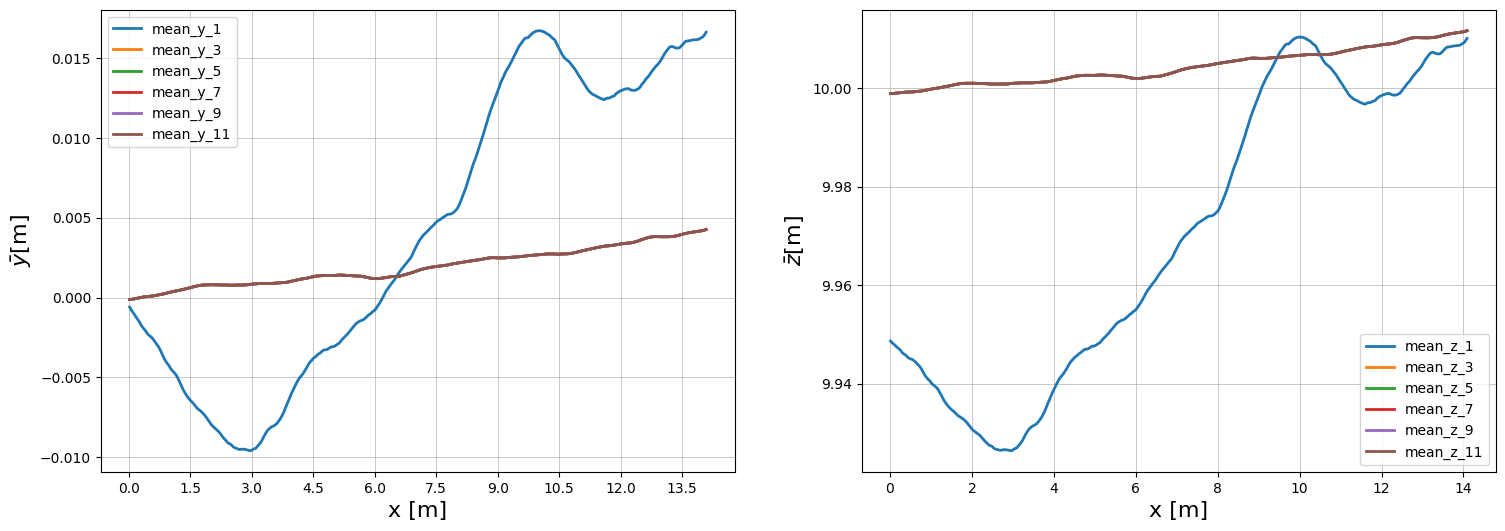

In [ ]:
plt.figure(figsize=(18, 6)) 

ax1 = plt.subplot(1,2,1)
plt.plot(x[0:len(x)-1], my_1[0:len(x)-1], linewidth = 2.0, label='mean_y_1')
plt.plot(x[0:len(x)-1], my_3[0:len(x)-1], linewidth = 2.0, label='mean_y_3')
plt.plot(x[0:len(x)-1], my_5[0:len(x)-1], linewidth = 2.0, label='mean_y_5')
plt.plot(x[0:len(x)-1], my_7[0:len(x)-1], linewidth = 2.0, label='mean_y_7')
plt.plot(x[0:len(x)-1], my_9[0:len(x)-1], linewidth = 2.0, label='mean_y_9')
plt.plot(x[0:len(x)-1], my_11[0:len(x)-1], linewidth = 2.0, label='mean_y_11')
plt.xlabel("x [m]", fontsize = 16)
plt.ylabel(r'$\bar{y}$[m]', fontsize = 16)
ax1.xaxis.set_major_locator(plt.MaxNLocator(15))
plt.grid(linewidth = 0.5)
plt.legend()

ax2 = plt.subplot(1,2,2)
plt.plot(x[0:len(x)-1], mz_1[0:len(x)-1], linewidth = 2.0, label='mean_z_1')
plt.plot(x[0:len(x)-1], mz_3[0:len(x)-1], linewidth = 2.0, label='mean_z_3')
plt.plot(x[0:len(x)-1], mz_5[0:len(x)-1], linewidth = 2.0, label='mean_z_5')
plt.plot(x[0:len(x)-1], mz_7[0:len(x)-1], linewidth = 2.0, label='mean_z_7')
plt.plot(x[0:len(x)-1], mz_9[0:len(x)-1], linewidth = 2.0, label='mean_z_9')
plt.plot(x[0:len(x)-1], mz_11[0:len(x)-1], linewidth = 2.0, label='mean_z_11')
plt.xlabel("x [m]", fontsize = 16)
plt.ylabel(r'$\bar{z}$[m]', fontsize = 16)
ax1.xaxis.set_major_locator(plt.MaxNLocator(15))
plt.grid(linewidth = 0.5)
plt.legend()

In [ ]:
dy_11 = d_y
dz_11 = d_z
my_11 = mean_y
mz_11 = mean_z

In [ ]:
dy_9 = d_y
dz_9 = d_z
my_9 = mean_y
mz_9 = mean_z
kky_9=kky
xx_9 = np.linspace(min(kky[:,len(x)-2]),max(kky[:,len(x)-2]),1000)
mmu_9, vvar_9 = norm.fit(kky[:,len(x)-2])
p_9 = norm.pdf(xx_9, mmu_9, vvar_9)

pdf_y_9 = p_9

kkz_9=kkz
xxx_9 = np.linspace(min(kkz[:,len(x)-2]),max(kkz[:,len(x)-2]),1000)
mmmu_9, vvvar_9 = norm.fit(kkz[:,len(x)-2])
pp_9 = norm.pdf(xxx_9, mmmu_9, vvvar_9)
pdf_z_9 = pp_9

In [ ]:
dy_7 = d_y
dz_7 = d_z
my_7 = mean_y
mz_7 = mean_z
kky_7=kky
xx_7 = np.linspace(min(kky[:,len(x)-2]),max(kky[:,len(x)-2]),1000)
mmu_7, vvar_7 = norm.fit(kky[:,len(x)-2])
p_7 = norm.pdf(xx_7, mmu_7, vvar_7)

pdf_y_7 = p_7

kkz_7=kkz
xxx_7 = np.linspace(min(kkz[:,len(x)-2]),max(kkz[:,len(x)-2]),1000)
mmmu_7, vvvar_7 = norm.fit(kkz[:,len(x)-2])
pp_7 = norm.pdf(xxx_7, mmmu_7, vvvar_7)
pdf_z_7 = pp_7

In [ ]:
dy_6 = d_y
dz_6 = d_z
my_6 = mean_y
mz_6 = mean_z
kky_6=kky
xx_6 = np.linspace(min(kky[:,len(x)-2]),max(kky[:,len(x)-2]),1000)
mmu_6, vvar_6 = norm.fit(kky[:,len(x)-2])
p_6 = norm.pdf(xx_6, mmu_6, vvar_6)

pdf_y_6 = p_6

kkz_6=kkz
xxx_6 = np.linspace(min(kkz[:,len(x)-2]),max(kkz[:,len(x)-2]),1000)
mmmu_6, vvvar_6 = norm.fit(kkz[:,len(x)-2])
pp_6 = norm.pdf(xxx_6, mmmu_6, vvvar_6)
pdf_z_6 = pp_6

In [ ]:
dy_5 = d_y
dz_5 = d_z
my_5 = mean_y
mz_5 = mean_z
kky_5=kky
xx_5 = np.linspace(min(kky[:,len(x)-2]),max(kky[:,len(x)-2]),1000)
mmu_5, vvar_5 = norm.fit(kky[:,len(x)-2])
p_5 = norm.pdf(xx_5, mmu_5, vvar_5)

pdf_y_5 = p_5

kkz_5=kkz
xxx_5 = np.linspace(min(kkz[:,len(x)-2]),max(kkz[:,len(x)-2]),1000)
mmmu_5, vvvar_5 = norm.fit(kkz[:,len(x)-2])
pp_5 = norm.pdf(xxx_5, mmmu_5, vvvar_5)
pdf_z_5 = pp_5

In [ ]:
dy_4 = d_y
dz_4 = d_z
my_4 = mean_y
mz_4 = mean_z
kky_4=kky
xx_4 = np.linspace(min(kky[:,len(x)-2]),max(kky[:,len(x)-2]),1000)
mmu_4, vvar_4 = norm.fit(kky[:,len(x)-2])
p_4 = norm.pdf(xx_4, mmu_4, vvar_4)

pdf_y_4 = p_4

kkz_4=kkz
xxx_4 = np.linspace(min(kkz[:,len(x)-2]),max(kkz[:,len(x)-2]),1000)
mmmu_4, vvvar_4 = norm.fit(kkz[:,len(x)-2])
pp_4 = norm.pdf(xxx_4, mmmu_4, vvvar_4)
pdf_z_4 = pp_4

In [ ]:
dy_3 = d_y
dz_3 = d_z
my_3 = mean_y
mz_3 = mean_z
x_3=x
kky_3=kky
xx_3 = np.linspace(min(kky[:,len(x)-2]),max(kky[:,len(x)-2]),1000)
mmu_3, vvar_3 = norm.fit(kky[:,len(x)-2])
p_3 = norm.pdf(xx_3, mmu_3, vvar_3)

pdf_y_3 = p_3

kkz_3=kkz
xxx_3 = np.linspace(min(kkz[:,len(x)-2]),max(kkz[:,len(x)-2]),1000)
mmmu_3, vvvar_3 = norm.fit(kkz[:,len(x)-2])
pp_3 = norm.pdf(xxx_3, mmmu_3, vvvar_3)
pdf_z_3 = pp_3

In [ ]:
dy_1 = d_y
dz_1 = d_z 
my_1 = mean_y
mz_1 = mean_z
x_1=x
kky_1=kky
xx_1 = np.linspace(min(kky[:,len(x)-2]),max(kky[:,len(x)-2]),1000)
mmu_1, vvar_1 = norm.fit(kky[:,len(x)-2])
p_1 = norm.pdf(xx_1, mmu_1, vvar_1)

pdf_y_1 = p_1

kkz_1=kkz
xxx_1 = np.linspace(min(kkz[:,len(x)-2]),max(kkz[:,len(x)-2]),1000)
mmmu_1, vvvar_1 = norm.fit(kkz[:,len(x)-2])
pp_1 = norm.pdf(xxx_1, mmmu_1, vvvar_1)
pdf_z_1 = pp_1

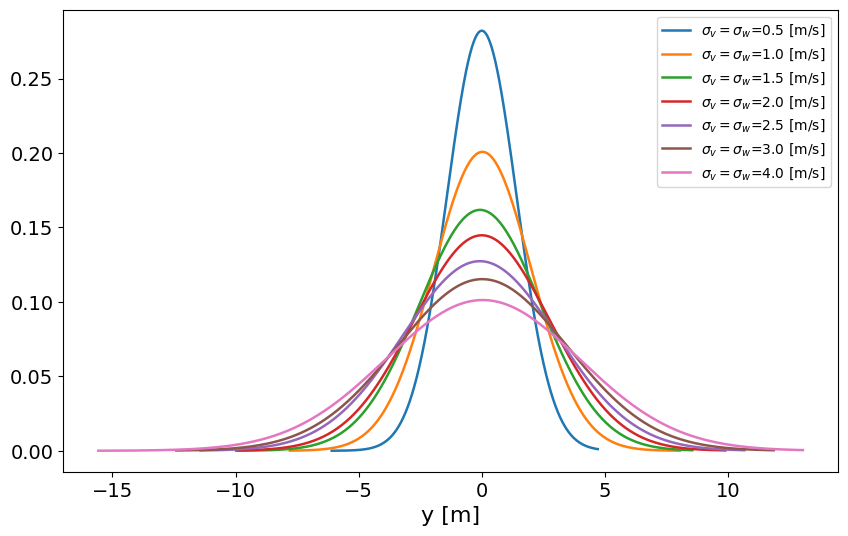

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6)) 
#sns.distplot(kky[:,len(x)-2],bins=50,ax=ax)
plt.plot(xx_1,p_1, linewidth = 1.8)
plt.plot(xx_3,p_3, linewidth = 1.8)
plt.plot(xx_4,p_4, linewidth = 1.8)
plt.plot(xx_5,p_5, linewidth = 1.8)
plt.plot(xx_6,p_6, linewidth = 1.8)
plt.plot(xx_7,p_7, linewidth = 1.8)
plt.plot(xx_9,p_9, linewidth = 1.8)
plt.legend([r'$\sigma_v = \sigma_w$=0.5 [m/s]',r'$\sigma_v = \sigma_w$=1.0 [m/s]',r'$\sigma_v = \sigma_w$=1.5 [m/s]',r'$\sigma_v = \sigma_w$=2.0 [m/s]',r'$\sigma_v = \sigma_w$=2.5 [m/s]',r'$\sigma_v = \sigma_w$=3.0 [m/s]',r'$\sigma_v = \sigma_w$=4.0 [m/s]'])
plt.xlabel("y [m]", fontsize = 16)
plt.tick_params(axis='both', labelsize=14)

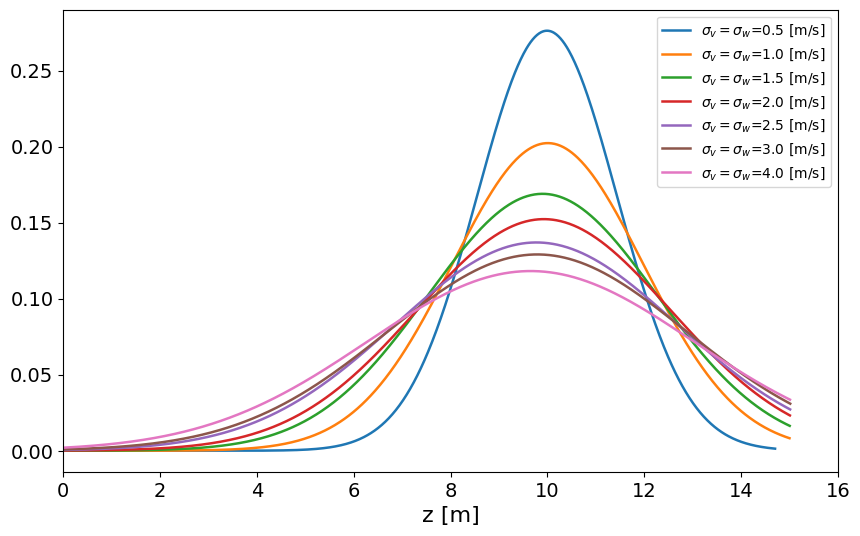

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
#sns.distplot(kkz[:,len(x)-2],bins=50,ax=ax)
plt.plot(xxx_1,pp_1, linewidth = 1.8)
plt.plot(xxx_3,pp_3, linewidth = 1.8)
plt.plot(xxx_4,pp_4, linewidth = 1.8)
plt.plot(xxx_5,pp_5, linewidth = 1.8)
plt.plot(xxx_6,pp_6, linewidth = 1.8)
plt.plot(xxx_7,pp_7, linewidth = 1.8)
plt.plot(xxx_9,pp_9, linewidth = 1.8)
plt.xlabel("z [m]", fontsize = 16)
plt.xlim([0,16])
plt.tick_params(axis='both', labelsize=14)
plt.legend([r'$\sigma_v = \sigma_w$=0.5 [m/s]',r'$\sigma_v = \sigma_w$=1.0 [m/s]',r'$\sigma_v = \sigma_w$=1.5 [m/s]',r'$\sigma_v = \sigma_w$=2.0 [m/s]',r'$\sigma_v = \sigma_w$=2.5 [m/s]',r'$\sigma_v = \sigma_w$=3.0 [m/s]',r'$\sigma_v = \sigma_w$=4.0 [m/s]'])

Calculation of the concentrations from the particles trajectories using the relation:

C = Q/U * pdf 

So the first step consists in the computation of the pdfs along the two directions.



C:\Users\utente\AppData\Local\Temp\ipykernel_19852\2155917725.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(kky[:,len(x)-2],bins=50,ax=ax)


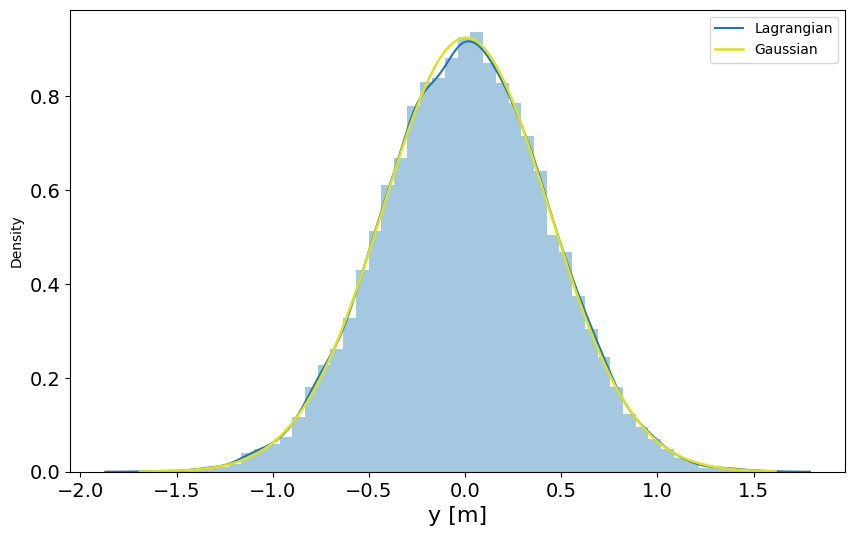

In [ ]:
# PDF along the y
# checking that it is actually a pdf and that is is a Gaussian one 

xx = np.linspace(min(kky[:,len(x)-2]),max(kky[:,len(x)-2]),1000)
mmu, vvar = norm.fit(kky[:,len(x)-2])
p = norm.pdf(xx, mmu, vvar)

pdf_y = p

fig, ax = plt.subplots(figsize=(10, 6)) 
sns.distplot(kky[:,len(x)-2],bins=50,ax=ax)
plt.plot(xx,p, linewidth = 1.8, color = colors[18])
plt.legend(['Lagrangian','Gaussian'])
plt.xlabel("y [m]", fontsize = 16)
plt.tick_params(axis='both', labelsize=14)


C:\Users\utente\AppData\Local\Temp\ipykernel_19852\2569621763.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(kkz[:,len(x)-2],bins=50,ax=ax)


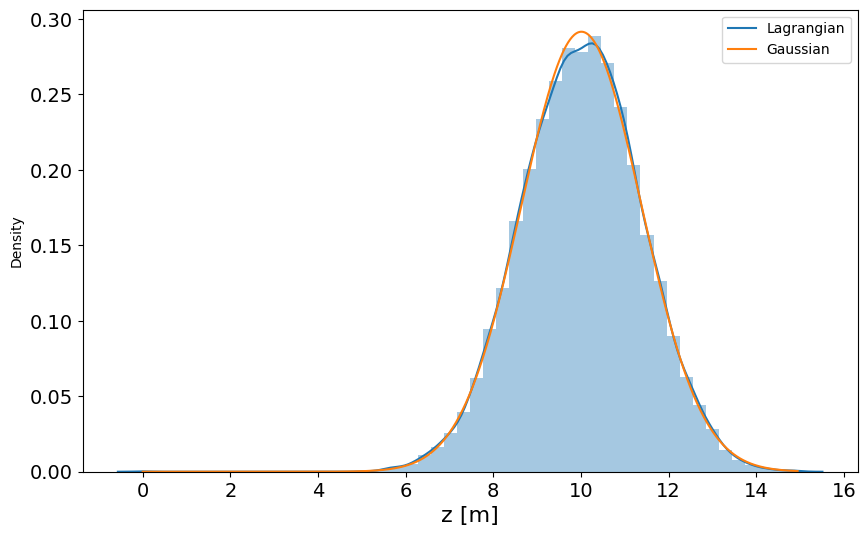

In [ ]:
# PDF along the z
# is it centered where you would expect it?

xxx = np.linspace(min(kkz[:,len(x)-2]),max(kkz[:,len(x)-2]),1000)
mmmu, vvvar = norm.fit(kkz[:,len(x)-2])
pp = norm.pdf(xxx, mmmu, vvvar)
pdf_z = pp

fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(kkz[:,len(x)-2],bins=50,ax=ax)
plt.plot(xxx,pp)
plt.xlabel("z [m]", fontsize = 16)
plt.tick_params(axis='both', labelsize=14)
plt.legend(['Lagrangian','Gaussian'])

In [ ]:
counts_z, bins_z = np.histogram(kkz[:,len(x)-2], bins = 999)
counts_y, bins_y = np.histogram(kky[:,len(x)-2], bins = 999)

In [ ]:
# computation of the concentration field in the (y,z) plane 

c = np.zeros([len(pdf_z),len(pdf_y)]) # concentration

for i in range(0,len(pdf_z)):
    for j in range(0,len(pdf_y)):
        c[i,j] = Q/U*pdf_z[i]*pdf_y[j]

C:\Users\utente\AppData\Local\Temp\ipykernel_19852\2602713785.py:2: UserWarning: The following kwargs were not used by contour: 'linewidth'
  contours = plt.contour(bins_y, bins_z, c, linewidth = 2.1)


(-1.0, 1.0)

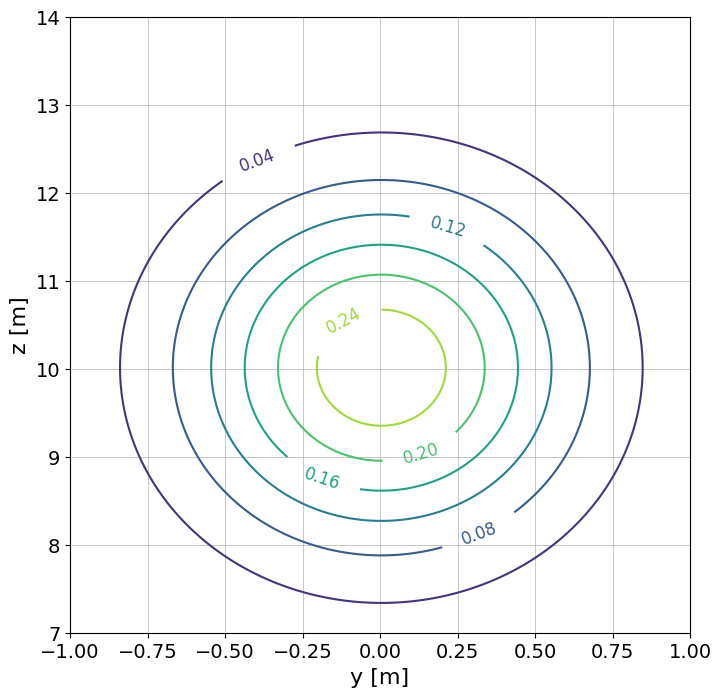

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 8))
contours = plt.contour(bins_y, bins_z, c, linewidth = 2.1)
plt.grid(linewidth = 0.5)
plt.tick_params(axis='both', labelsize=14)
plt.xlabel("y [m]", fontsize = 16)
plt.ylabel("z [m]", fontsize = 16)
plt.clabel(contours, inline=1, fontsize=12)
plt.ylim([7, 14])
plt.xlim([-1,1])

C:\Users\utente\AppData\Local\Temp\ipykernel_19852\332517454.py:2: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(bins_y, bins_z, c, linewidth = 2.1)


Text(0, 0.5, 'z [m]')

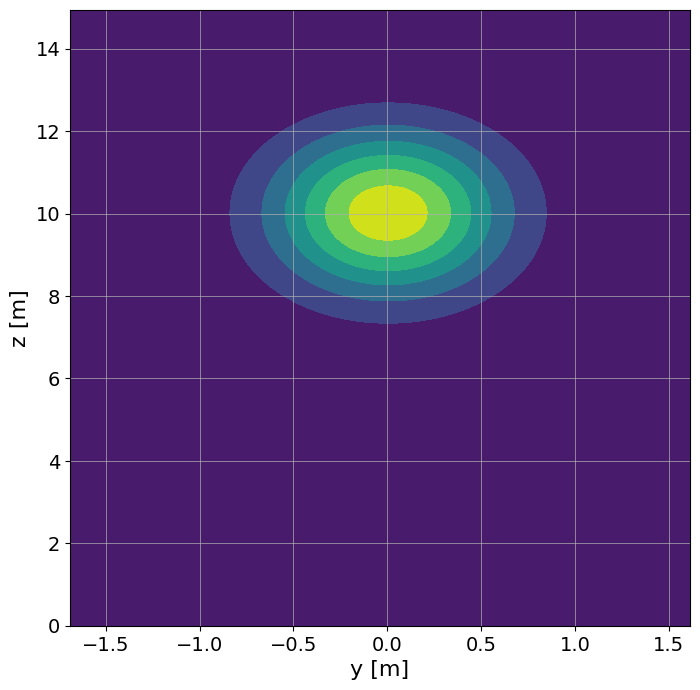

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 8))
plt.contourf(bins_y, bins_z, c, linewidth = 2.1)
plt.grid(linewidth = 0.5)
plt.tick_params(axis='both', labelsize=14)
plt.xlabel("y [m]", fontsize = 16)
plt.ylabel("z [m]", fontsize = 16)


Now, we check if the concentration obtained with the Gaussian (analytical) model and that obtained with the Lagrangian approach are the same. 

C:\Users\utente\AppData\Local\Temp\ipykernel_19852\603194661.py:20: UserWarning: The following kwargs were not used by contour: 'linewidth'
  contours = plt.contour(y,z, c_1, linewidth = 0.5)


<a list of 5 text.Text objects>

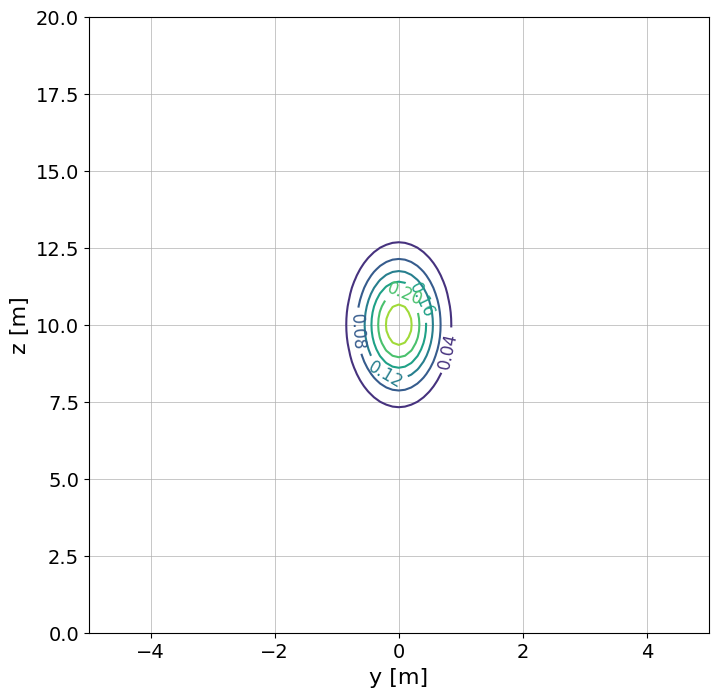

In [ ]:
# compute the concentration field using a Gaussian model 
# hint: you just have to understand what are the approximations that we are using in this exercise and 
# identify the right analytical expression for it
# pay attention to the boundary conditions (BC) and in particular to the lower boundary (i.e.: the ground)
n = 100
he=10
x = np.linspace(0,10,n+1)
n = 100
y = np.linspace(-5,5,n+1)
n = 100
z = np.linspace(0,20,n+1)
c_1 = np.zeros([len(y),len(z)])
slz= d_z[len(d_z)-1]
sly= d_y[len(d_y)-1]
for i in range(0,len(y)):
    for j in range(0,len(z)):
        c_1[j][i] = (Q/(2*np.pi*slz*sly*U))*np.exp(-y[i]**2/(2*(sly**2)))*(np.exp(-(z[j]-he)**2/(2*slz**2))+np.exp(-(z[j]+he)**2/(2*slz**2)))
#print(c_1)
fig, ax1 = plt.subplots(figsize=(8, 8))
contours = plt.contour(y,z, c_1, linewidth = 0.5)
plt.grid(linewidth = 0.5)
plt.tick_params(axis='both', labelsize=14)
plt.xlabel("y [m]", fontsize = 16)
plt.ylabel("z [m]", fontsize = 16)
plt.clabel(contours, inline=1, fontsize=12)
#plt.ylim([0, 7])
#plt.xlim([-1.5,1.5])




C:\Users\utente\AppData\Local\Temp\ipykernel_19852\2419612900.py:14: UserWarning: The following kwargs were not used by contour: 'linewidth'
  contours = plt.contour(y,z, c_2, linewidth = 0.5)


<a list of 5 text.Text objects>

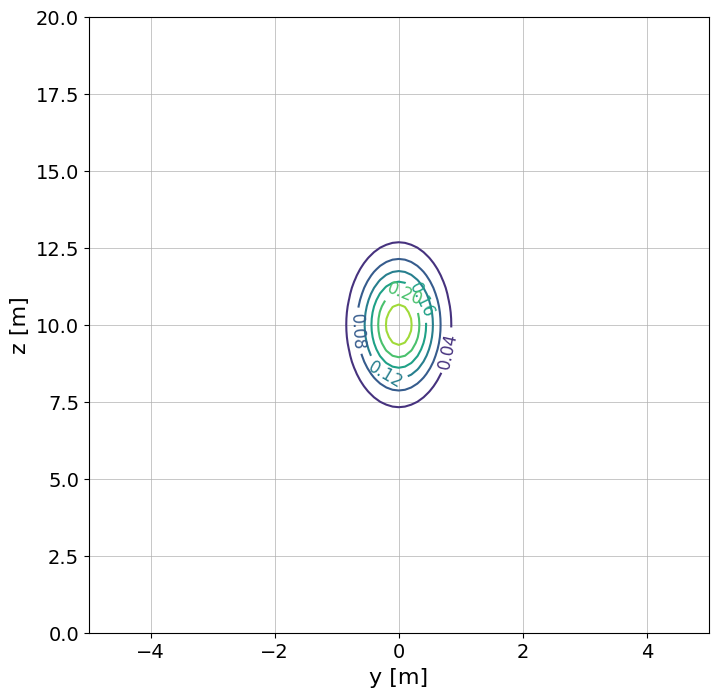

In [ ]:
# plot both the concentration fields in the same in order to perform a first visual check
# you can do this comparison considering a section in the (y,z) plane, as in the previous representations of the field 



he=10
c_2=np.zeros([len(y),len(z)])
for i in range(0,len(y)):
    for j in range(0,len(z)):
        for m in range(-100, 101):
           c_2[j][i] = c_2[j][i] + (Q/(2*np.pi*sly*slz*U))*np.exp(-y[i]**2/(2*(sly**2)))*np.exp((-(z[j]+2*m*pblh-he)**2)/(2*slz**2)+ np.exp(-(z[j]+2*m*pblh+he)**2)/(2*slz**2))

fig, ax1 = plt.subplots(figsize=(8, 8))
contours = plt.contour(y,z, c_2, linewidth = 0.5)
plt.grid(linewidth = 0.5)
plt.tick_params(axis='both', labelsize=14)
plt.xlabel("y [m]", fontsize = 16)
plt.ylabel("z [m]", fontsize = 16)
plt.clabel(contours, inline=1, fontsize=12)
#plt.ylim([0, 7])
#plt.xlim([-1.5,1.5])


C:\Users\utente\AppData\Local\Temp\ipykernel_19852\38240494.py:6: UserWarning: The following kwargs were not used by contour: 'linewidth'
  c1 = ax1.contour(y, z, c_2, linewidth=1, colors='red')
C:\Users\utente\AppData\Local\Temp\ipykernel_19852\38240494.py:7: UserWarning: The following kwargs were not used by contour: 'linewidth'
  c2 = ax1.contour(bins_y, bins_z, c, linewidth=1, alpha=0.8, colors='blue')


(7.0, 13.0)

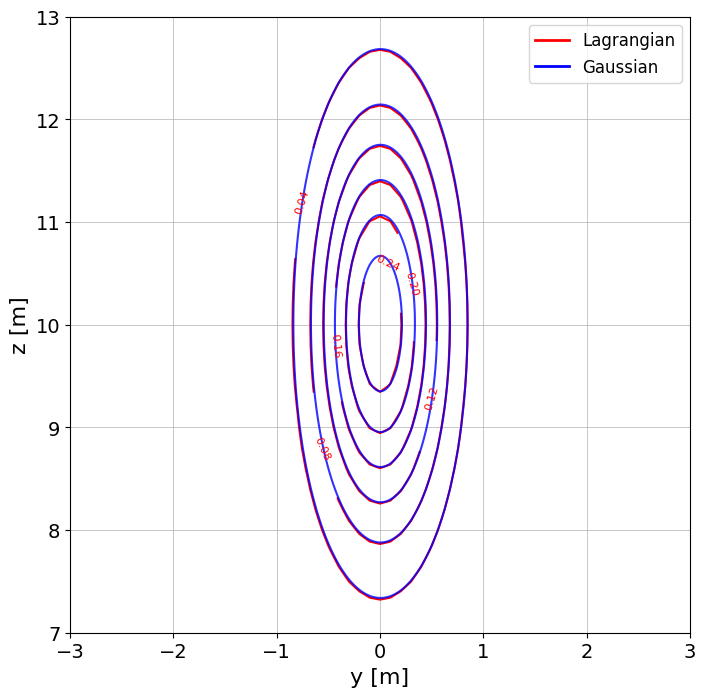

In [ ]:
# compare the two concentration fields using some statistics (mean error and so on, 
# you can choose whatever you think makes more sense or ask me)
from matplotlib.lines import Line2D

fig, ax1 = plt.subplots(figsize=(8, 8))
c1 = ax1.contour(y, z, c_2, linewidth=1, colors='red')
c2 = ax1.contour(bins_y, bins_z, c, linewidth=1, alpha=0.8, colors='blue')
ax1.clabel(c1, inline=1, fontsize=8)

legend_elements = [Line2D([0], [0], color='red', lw=2, label='Lagrangian'),
                   Line2D([0], [0], color='blue', lw=2, label='Gaussian')]
ax1.legend(handles=legend_elements, fontsize=12)

plt.grid(linewidth=0.5)
plt.tick_params(axis='both', labelsize=14)
plt.xlabel("y [m]", fontsize=16)
plt.ylabel("z [m]", fontsize=16)
plt.xlim([-3, 3])
plt.ylim([7,13])




In [ ]:
# Try again the exercise of the SENSITIVITY ANALYSIS: try different configurations of the initial 
# set of parameters to identify possible conditions in which the differences between the Lagrangian 
# and the Gaussian approaches are stronger




In [ ]:
nstep = 1000          # number of time steps
TL = .47              # Lagrangian integral time scale          
dt = TL/100           # time increment
C0 = 4                # constant C0 of Langevin equation  
N = 2000             # number of particles
U = 3                 # mean wind
Q = 3                 # emission rate
pblh = 15             # PBL height
he = 10               # height of the source

#variances of random numbers for initializing the particles velocities 

sigmav2 = .47089      #along y
sigmaw2 = 4.7089      #along z

#standard deviations of randon numbers for initializing the particles positions

sy = .0176239          #sy takes source size along y into account 
sz = .0176239          #sz takes source size along z into account 


In [ ]:
# Initilization of random variables

#Index for random terms
rr = 1

#random number with variance dt
mu, sigma = 0, np.sqrt(dt)
random = np.random.normal(mu, sigma, N*nstep+10)


#random numbers to initialize the velocities 
sigmav2 = .047089  
sigmaw2 = .47089  
epsilon_v = 2*sigmav2/(C0*TL)
epsilon_w = 2*sigmaw2/(C0*TL)
random_vv = np.random.normal(0.0, np.sqrt(sigmav2), N)
random_ww = np.random.normal(0.0, np.sqrt(sigmaw2), N)
# Position at the source 

# sy sz take the source size into account.
sy = .0176239  
sz = .0176239 

# height of the source (H)
he = 10.0

random_yy = np.random.normal(0.0, sy, N)
random_zz= np.random.normal(he, sz, N) 

kky = np.zeros([N,nstep])
kkz = np.zeros([N,nstep])
time = np.zeros([nstep,1])

# cycling now on all the particles

for n in range(1,N-1):
    # initialization of the positions
    yy = random_yy[n]
    zz = random_zz[n]
    
    # initialization of the velocities 
    vm = random_vv[n]
    wm = random_ww[n]
    
    for step in range(0,nstep-1):
        if n ==1:
            time[1] = dt
        else:
            time[step] = time[step-1]+dt
    
    # computation of the coefficients a and b for the systems of Langevin and position equation for y and z 
    # the definition of a is done using the Hinze relationship between the Lagrangian time scale and the dissipation rate
    # [Hinze relation:  C0*epsilon = 2sigmau^2/TL]
    
        av = -vm/TL
        bv = np.sqrt(C0*epsilon_v)
        aw = -wm/TL
        bw = np.sqrt(C0*epsilon_w)
    
    # computation of the positions and the velocities at the new timestep
        vm = vm + av*dt + bv*random[rr]
        yy = yy + vm*dt
        wm = wm + aw*dt + bw*random[rr]
        zz = zz + wm*dt
   
    # boundary conditions 
        if zz <= 0:
            wm = abs(wm)
            zz = zz
            # lower boundary
    
        if zz >= pblh:
            print(wm)
            wm = -abs(wm) # cambiare questo per deposizione
            zz = zz
            # higher boundary
    
        kky[n,step] = yy
        kkz[n,step] = zz
    
        rr=rr+1
        
# end of the cycle for the timestep
# end of the cycle on the particles
# Evaluating the range to check if the boundary conditions are respected in the z direction 

print(np.min(kkz))
print(np.max(kkz))

print(np.min(kky))
print(np.max(kky))

x = U*time

0.0
14.500398426592106
-1.368865825456488
1.4118064649181956


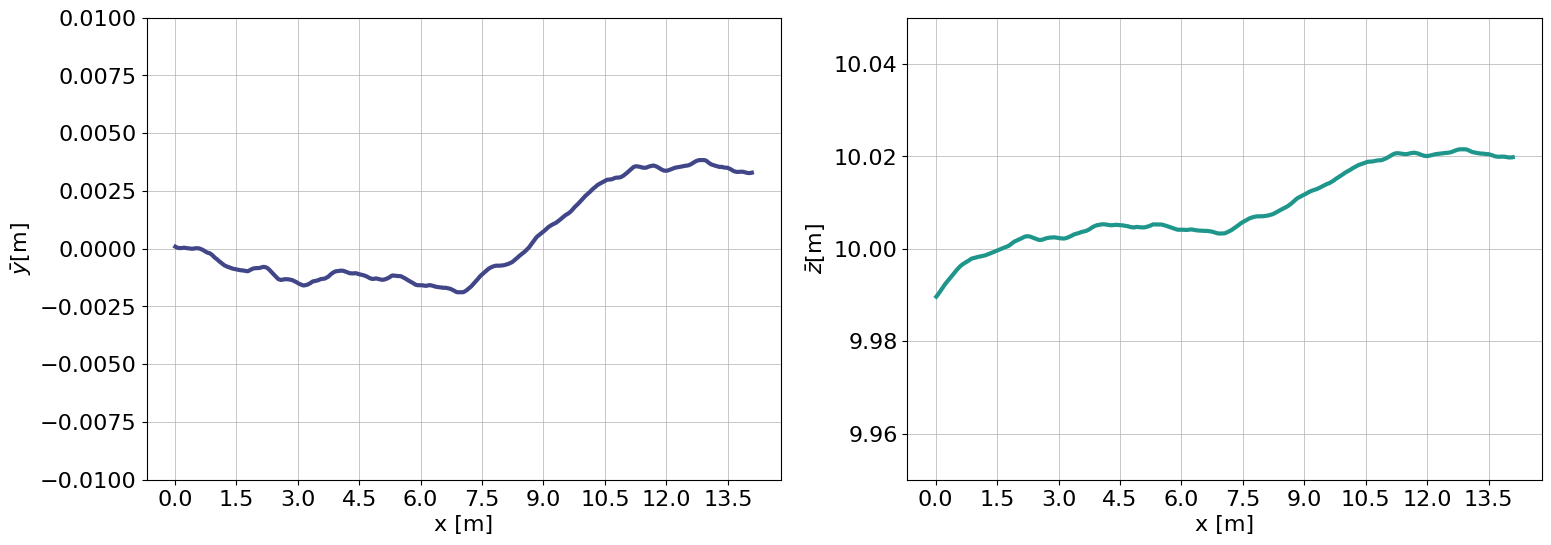

In [ ]:
# mean trajectories along y and z 
#volevo fare un grafico con il valor medio con N=2000 e con N=20000
mean_y1 = np.mean(kky[:,0:len(x)-1],0)
mean_z1 = np.mean(kkz[:,0:len(x)-1],0)

plt.figure(figsize=(18, 6)) 

ax1 = plt.subplot(1,2,1)
plt.plot(x[0:len(x)-1], mean_y1[0:len(x)-1], linewidth = 3.0, color = colors[4])
plt.xlabel("x [m]", fontsize = 16)
plt.ylabel(r'$\bar{y}$[m]', fontsize = 16)
ax1.xaxis.set_major_locator(plt.MaxNLocator(15))
plt.ylim([-0.01, 0.01])
plt.tick_params(axis='both', labelsize=16)
plt.grid(linewidth = 0.5)

ax2 = plt.subplot(1,2,2)
plt.plot(x[0:len(x)-1], mean_z1[0:len(x)-1], linewidth = 3.0, color = colors[10])
plt.xlabel("x [m]", fontsize = 16)
plt.ylabel(r'$\bar{z}$[m]', fontsize = 16)
ax2.xaxis.set_major_locator(plt.MaxNLocator(15))
plt.ylim([9.95, 10.05])
plt.tick_params(axis='both', labelsize=16)
plt.grid(linewidth = 0.5)

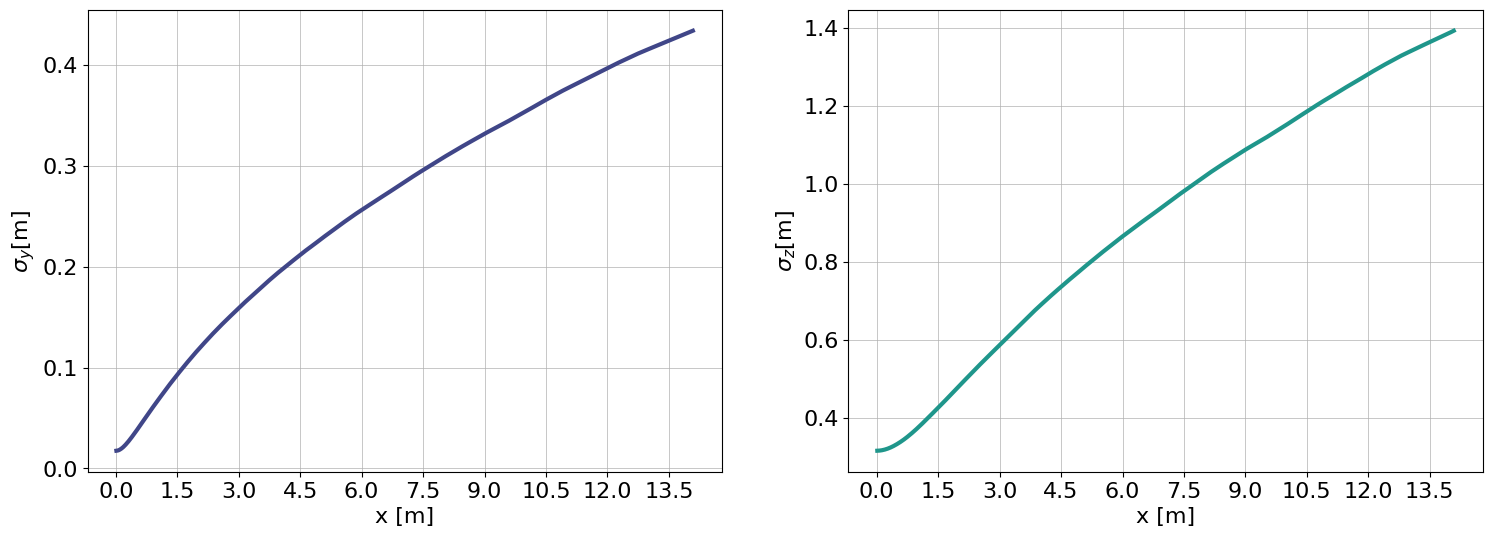

In [ ]:
d_y = np.std(kky[:,0:len(x)-1],0)
d_z = np.std(kkz[:,0:len(x)-1],0)
plt.figure(figsize=(18, 6)) 

ax1 = plt.subplot(1,2,1)
plt.plot(x[0:len(x)-1], d_y[0:len(x)-1], linewidth = 3.0, color = colors[4])
plt.xlabel("x [m]", fontsize = 16)
plt.ylabel(r'$\sigma_y$[m]', fontsize = 16)
ax1.xaxis.set_major_locator(plt.MaxNLocator(15))
#plt.ylim([-0.01, 0.01])
plt.tick_params(axis='both', labelsize=16)
plt.grid(linewidth = 0.5)

ax2 = plt.subplot(1,2,2)
plt.plot(x[0:len(x)-1], d_z[0:len(x)-1], linewidth = 3.0, color = colors[10])
plt.xlabel("x [m]", fontsize = 16)
plt.ylabel(r'$\sigma_z$[m]', fontsize = 16)
ax2.xaxis.set_major_locator(plt.MaxNLocator(15))
#plt.ylim([9.95, 10.05])
plt.tick_params(axis='both', labelsize=16)
plt.grid(linewidth = 0.5)